<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/Demo_optimize_monochromatic_neural_metalens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DFlat is built on top of Tensorflow's Keras. If you want to use GPU speedup for all executions, click runtime at the top and enable GPU acceleration. This is recommended to get results ~20-30x faster


# Cloning and Installing the repository


This may take a minute or two so be patient! We are working to optimize repository size and structure. 

In [ ]:
!git lfs instal!git lfs install
!git clone https://github.com/DeanHazineh/DFlat

%cd /content/DFlat
!python setup.py develop

Error: unknown command "instal!git" for "git-lfs"
Run 'git-lfs --help' for usage.
Cloning into 'DFlat'...
remote: Enumerating objects: 3101, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 3101 (delta 47), reused 83 (delta 30), pack-reused 2977
Receiving objects: 100% (3101/3101), 766.57 MiB | 8.08 MiB/s, done.
Resolving deltas: 100% (1103/1103), done.
Updating files: 100% (357/357), done.
Filtering content: 100% (19/19), 77.20 MiB | 69.34 MiB/s, done.
/content/DFlat
running develop
running egg_info
creating DFlat.egg-info
writing DFlat.egg-info/PKG-INFO
writing dependency_links to DFlat.egg-info/dependency_links.txt
writing top-level names to DFlat.egg-info/top_level.txt
writing manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'DFlat.egg-info/SOURCES.txt'
running build_ext
Creating 

In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.7/157.7 KB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 111.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
  Created wheel for gdspy: filename=gdspy-1.6.12-cp38-cp38-linux_x86_64.whl size=597243 sha256=d3fffcb6a7aa56a19688493e220541351c74c133276c9d18bb21c2c5739616a4
  Stored in directory: /root/.cache/pip/wheels/03/ed/d5/f89483da9ebf5b67e58ba967e19132ae7703a6409727790445
Successfully built gdspy
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12

# Create a metasurface optimization pipeline using the PSF_layer for differentiable field propagation and the neural_optical model as the field solver 

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

import dflat.optimization_helpers as df_optimizer
import dflat.fourier_layer as df_fourier
import dflat.neural_optical_layer as df_neural
import dflat.data_structure as df_struct
import dflat.plot_utilities as plt_util

We first build an optimization class inheriting from the df_optimizer.Pipeline_Object (although you can choose to not use this).

By inheriting this class, all the details of saving and loading custom model checkpoints are taken care of. Moreover, this class allows us to use convenient, pre-written functions for training loops, enabling faster prototyping.  

Most of the lines below are used to define the visualizeTrainingCheckpoint. This is a plotting functions that will be called during save checkpoints (intermediary epochs) to monitor the process when using the training helpers in the df_optimizer module! Defining this function overides the parent empy function and is entirely optional! If not included, no visualization plots will be made but the code will still run.

In the collab, these plots wont actually save since no google drive or harddrive is mounted but that is okay! we can always view plots manually at the end by tweaking the code and calling the function with plt.show()

In [ ]:
df_neural.list_models()

['ERBF_Nanocylinders_B1024_U180_H600', 'ERBF_Nanofins_B4096_U350_H600', 'MLP_Nanocylinders_Dense256_U180_H600', 'MLP_Nanofins_Dense1024_U350_H600', 'MLP_Nanofins_Dense512_U350_H600']


For this example, we are going to inverse-design/rediscover a polarization-insensitive metasurface, built from nanocylinders, that focuses light.

In [ ]:
class pipeline_Metalens_MLP(df_optimizer.Pipeline_Object):
    def __init__(self, propagation_parameters, point_source_locs, savepath, saveAtEpochs=None):
        super(pipeline_Metalens_MLP, self).__init__(savepath, saveAtEpochs)

        # Add inputs to class attributes
        self.propagation_parameters = propagation_parameters
        self.point_source_locs = point_source_locs

        # define computational layers
        mlp_model = "MLP_Nanocylinders_Dense256_U180_H600"
        self.mlp_latent_layer = df_neural.MLP_Latent_Layer(mlp_model)
        self.psf_layer = df_fourier.PSF_Layer(propagation_parameters)  

        # Define initial starting condition for the metasurface latent tensor
        init_latent_tensor = tf.zeros(propagation_parameters["grid_shape"], dtype=tf.float64)
        self.latent_tensor_variable = tf.Variable(init_latent_tensor, trainable=True, dtype=tf.float64)

        ## The lens could be initialized in another state like a focusing lens:
        # focus_trans, focus_phase, _, _ = df_fourier.focus_lens_init(propagation_parameters, [532e-9], [0.3], [{"x": 0, "y": 0}])
        # _, norm_param = df_library.optical_response_to_param([focus_trans], [focus_phase], [532e-9], "Nanocylinders_U180nm_H600nm", reshape=True)
        # init_latent_tensor = df_tools.param_to_latent(init_norm_param)
        # self.latent_tensor_variable = tf.Variable(init_latent_tensor, trainable=True, dtype=tf.float64)

        return

    def __call__(self):
        # Compute the PSF
        wavelength_set_m = self.propagation_parameters["wavelength_set_m"]
        out = self.mlp_latent_layer(self.latent_tensor_variable, wavelength_set_m)
        psf_intensity, psf_phase = self.psf_layer(out, self.point_source_locs)

        # Save the last lens and psf for plotting later
        self.last_lens = out
        self.last_psf = psf_intensity

        return psf_intensity

    def visualizeTrainingCheckpoint(self, saveto):
        # This overrides the baseclass visualization call function, called during checkpoints
        savefigpath = self.savepath + "/trainingOutput/"
        radial_flag = self.propagation_parameters["radial_symmetry"]

        # Helper call that returns simple definition of cartesian axis on lens and output space (mm)
        xl, yl = plt_util.get_lens_pixel_coordinates(self.propagation_parameters)
        xd, yd = plt_util.get_detector_pixel_coordinates(self.propagation_parameters)
        xl, yl = xl * 1e3, yl * 1e3
        xd, yd = xd * 1e3, yd * 1e3

        # Plot Grab some items we want to visualize
        # Latent tensor can be converted back to the physical shape dimensions
        latent_tensor_state = self.latent_tensor_variable.numpy()
        shapeVector = np.squeeze(self.mlp_latent_layer.latent_to_unnorm_shape(latent_tensor_state))
        trans = np.squeeze(self.last_lens[0])
        phase = np.squeeze(self.last_lens[1])

        fig = plt.figure(figsize=(20, 5))
        axList = plt_util.addAxis(fig, 1, 3)
        lens_extent = (min(xl), max(xl), max(yl), min(yl))
        det_extent = (min(xd), max(xd), max(yd), min(yd))
        if radial_flag:
            axList[0].plot(xl, shapeVector * 1e9)
            plt_util.formatPlots(fig, axList[0], None, xlabel="lens x (mm)", ylabel="radius length (nm)",
                                 setAspect="auto", fontsize_text=12, fontsize_title=12, fontsize_ticks=12)
            axList[1].plot(xl, phase, "bx-")
            axList[1].plot(xl, trans, "kx-")
            plt_util.formatPlots(fig, axList[1], None, xlabel="lens x (mm)", ylabel="Trans and Phase", 
                                 setAspect="auto", fontsize_text=12, fontsize_title=12, fontsize_ticks=12)
        else:
            im0 = axList[0].imshow(shapeVector * 1e9, extent=lens_extent)
            plt_util.formatPlots(fig, axList[0], im0, xlabel="lens x (mm)", ylabel="lens y (nm)", title="Learned Metasurface",
                                 setAspect="equal", addcolorbar=True, cbarTitle="Radius (nm)", fontsize_text=12, fontsize_title=12, fontsize_ticks=12)
            im1 = axList[1].imshow(phase, extent=lens_extent, vmin=-np.pi, vmax=np.pi)
            plt_util.formatPlots(
                fig, axList[1], im1, xlabel="lens x (mm)", ylabel="lens y (mm)", title="Learned Phase",
                setAspect="equal",addcolorbar=True,cbarTitle="Phase (radians)", fontsize_text=12, fontsize_title=12, fontsize_ticks=12)

        # Plot the recent PSF
        im = axList[2].imshow(self.last_psf[0,0, 0], extent=det_extent)
        plt_util.formatPlots(
            fig, axList[2], im, xlabel="det x (mm)", ylabel="det y (mm)", title="PSF Intensity", 
            addcolorbar=True, setAspect="equal", fontsize_text=12, fontsize_title=12, fontsize_ticks=12
        )

        plt.savefig(savefigpath + "png_images/" + saveto + "epoch_checkpointFig.png")
        plt.savefig(savefigpath + "pdf_images/" + saveto + "epoch_checkpointFig.pdf")
        #plt.close()
        plt.show()
        return

# Define Simulation Settings and run the optimization

We can write a simple function that will initialize our optimization pipeline class and train it! 

In this example, we will not write a custom, new training loop. Instead, we will import and use df_optimizer.run_pipeline_optimization function. This takes in a class that inherits df_optimizer.Pipeline_Object like done above.  

To train with this call, we define a loss function. Below, this is done in loss_fn. Note that currently when using this approach, the loss function can only take "pipeline_output" as an input! This means that the loss function should be defined explicitly in terms of the pipeline call function. 

If you do not like this, a new custom trainer can be written. An example on how to do this will be shown later but you can also open up and see the code in the df_optimizer.run_pipeline_optimization function to get an idea. Alternatively, you can also read the Tensorflow tutorial on gradient optimization. 


In [ ]:
def optimize_metalens_mlp(radial_symmetry, num_epochs=30, try_gpu=True):
  savepath = "examples/output/metalens_example_radial" + str(radial_symmetry) + "/"
  if not os.path.exists(savepath):
      os.makedirs(savepath)

  # Define propagation parameters for psf calculation
  propagation_parameters = df_struct.prop_params(
      {
          "wavelength_set_m": [532e-9],  
          "ms_samplesM": {"x": 555, "y": 555},
          "ms_dx_m": {"x": 10 * 180e-9, "y": 10 * 180e-9},
          "radius_m": 1.0e-3 / 2.0,
          "sensor_distance_m": 10e-3,
          "initial_sensor_dx_m": {"x": 1e-6, "y": 1e-6},
          "sensor_pixel_size_m": {"x": 1e-6, "y": 1e-6},
          "sensor_pixel_number": {"x": 501, "y": 501},
          "radial_symmetry": radial_symmetry,
          #"diffractionEngine": "fresnel_fourier", #You can also use ASM_fourier for the angular spectrum method calculation
          "diffractionEngine": "ASM_fourier", #You can also use ASM_fourier for the angular spectrum method calculation
          ### Optional keys
          "automatic_upsample": False,  # If true, it will try to automatically determine good upsample factor for calculations
          "manual_upsample_factor": 1,  # Otherwise you can manually dictate upsample factor
      })
  df_struct.print_full_settings(propagation_parameters)

  # Point_source locs we want to compute the psf for
  point_source_locs = np.array([[0.0, 0.0, 1e6]])  # on-axis ps at 1e6 m away (~infinity)

  # Call the pipeline
  saveAtEpoch = 10 
  pipeline = pipeline_Metalens_MLP(propagation_parameters, point_source_locs, savepath, saveAtEpochs=saveAtEpoch)
  # pipeline.customLoad()  # restore previous training checkpoint if it exists

  # Define custom Loss function (Should always have pipeline_output as the function input if you use the helper)
  # Otherwise you can easily write your own train loop for more control
  sensor_pixel_number = propagation_parameters["sensor_pixel_number"]
  cidx_y = sensor_pixel_number["y"] // 2
  cidx_x = sensor_pixel_number["x"] // 2

  def loss_fn(pipeline_output):
      return -pipeline_output[0, 0, 0, cidx_y, cidx_x]

  learning_rate = 2e-2
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  df_optimizer.run_pipeline_optimization(pipeline, optimizer, num_epochs=num_epochs, loss_fn=tf.function(loss_fn), allow_gpu=try_gpu)
  return

Run with radial symmetry Flag. Only a radial vector for the metasurface is trained and fields are propagated using an efficient, approximate Hankel transform


 OVERVIEW OF PARAMETERS 


 wavelength_m 5.32e-07

 ms_length_m:  {'x': 0.0009989999999999999, 'y': 0.0009989999999999999}

 ms_dx_m:  {'x': 1.8e-06, 'y': 1.8e-06}

 calc_ms_dx_m:  {'x': 1e-06, 'y': 1e-06}

 ms_samplesM:  {'x': 555, 'y': 555, 'r': 278}

 calc_samplesM:  {'x': 999, 'y': 999, 'r': 500}

 calc_samplesN:  {'x': 999, 'y': 999, 'r': 500}

 initial_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 calc_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel_size_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel_number:  {'x': 501, 'y': 501}


Checking for model checkpoint at: /content/DFlat/dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanocylinders_Dense256_U180_H600/

 Model Checkpoint Loaded 

Loaded Model:  MLP_Nanocylinders_Dense256_U180_H600


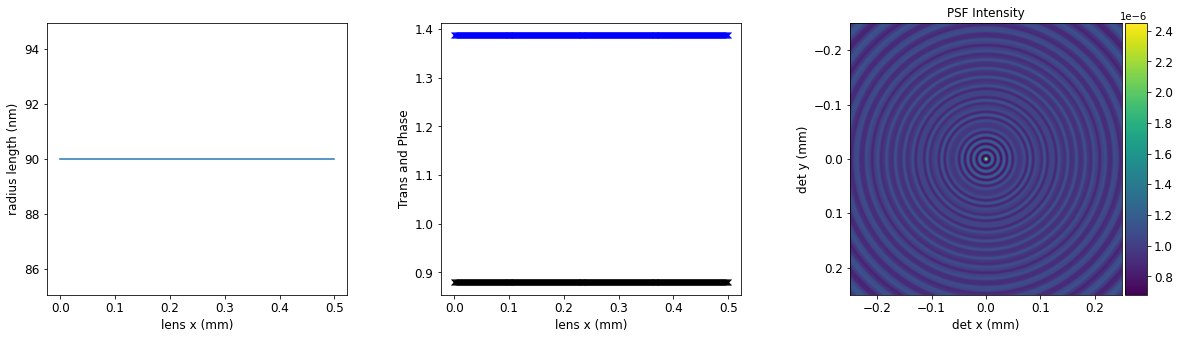

Training Log | (Step, time, loss):  0 3.974032402038574 -2.4498290782822467e-06
Training Log | (Step, time, loss):  1 2.9764444828033447 -0.0005153070263635286
Training Log | (Step, time, loss):  2 2.8949272632598877 -0.0015394530878719004
Training Log | (Step, time, loss):  3 4.106775522232056 -0.002869767072349192
Training Log | (Step, time, loss):  4 3.6892929077148438 -0.004412701789198012
Training Log | (Step, time, loss):  5 2.9180068969726562 -0.0061049935093671044
Training Log | (Step, time, loss):  6 2.908987522125244 -0.007729898975404779
Training Log | (Step, time, loss):  7 3.293206214904785 -0.009332306923872255
Training Log | (Step, time, loss):  8 4.44045615196228 -0.010994008694932476
Training Log | (Step, time, loss):  9 2.8783974647521973 -0.013708908757074098
Log Training at step: 10


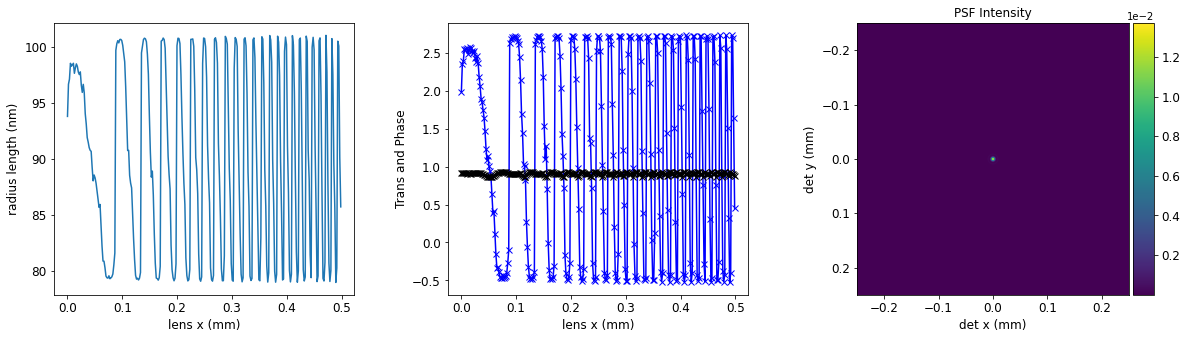

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:74: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")


Training Log | (Step, time, loss):  10 2.916055917739868 -0.015932333381218595
Training Log | (Step, time, loss):  11 4.026947021484375 -0.0170720994190431
Training Log | (Step, time, loss):  12 4.646100044250488 -0.017895160827617853
Training Log | (Step, time, loss):  13 2.9753968715667725 -0.018483470599876674
Training Log | (Step, time, loss):  14 3.4187750816345215 -0.018928790895754413
Training Log | (Step, time, loss):  15 4.670819520950317 -0.019264343475540634
Training Log | (Step, time, loss):  16 3.4661941528320312 -0.019508637978098268
Training Log | (Step, time, loss):  17 2.9455723762512207 -0.01968563972268217
Training Log | (Step, time, loss):  18 2.9318172931671143 -0.019824362722436553
Training Log | (Step, time, loss):  19 3.721374750137329 -0.019924166534937577
Log Training at step: 20


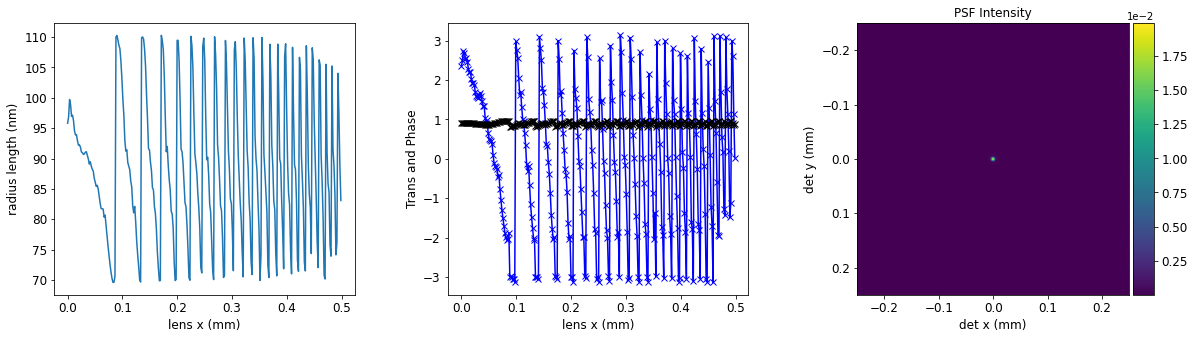

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:74: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")


Training Log | (Step, time, loss):  20 3.1145176887512207 -0.020008609800043934
Training Log | (Step, time, loss):  21 2.930880546569824 -0.02008109486225211
Training Log | (Step, time, loss):  22 2.92215633392334 -0.020156993564139785
Training Log | (Step, time, loss):  23 4.097337007522583 -0.020230988025646632
Training Log | (Step, time, loss):  24 3.7616968154907227 -0.020306456189146962
Training Log | (Step, time, loss):  25 2.8890175819396973 -0.020367030003622756
Training Log | (Step, time, loss):  26 2.908313512802124 -0.020416884897597628
Training Log | (Step, time, loss):  27 3.2062833309173584 -0.020457376305201953
Training Log | (Step, time, loss):  28 4.503934144973755 -0.02050609866730674
Training Log | (Step, time, loss):  29 2.909653663635254 -0.020561634246674093
Log Training at step: 30


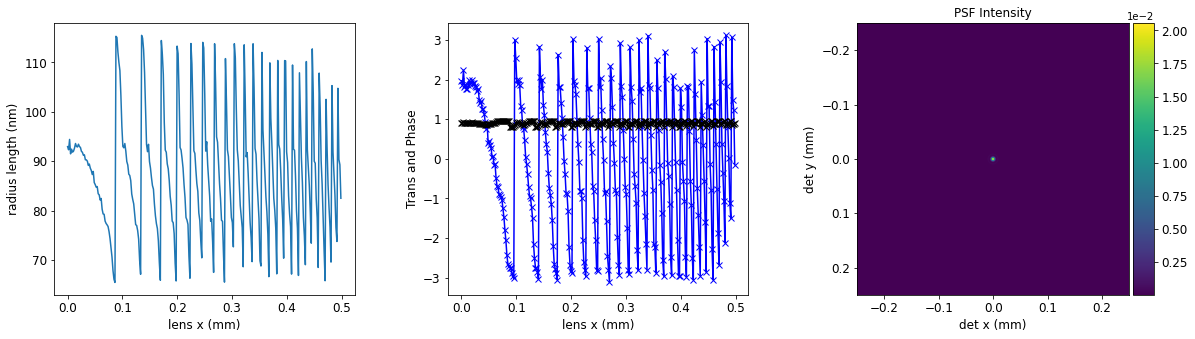

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:74: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")



 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:74: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")


In [ ]:
optimize_metalens_mlp(radial_symmetry=True, num_epochs=30, try_gpu=True)

Now run without radial symmetry Flag. The 2D metasurface will be assembled and 2D fields will be propagated instead. Cool, asymmetric PSFs can in theory be discovered like this but the memory costs are higher! Just like when training standard deep neural networks for computer vision, DFlat can be paired with neural nets and should be trained on a GPU cluster or similar resources.


 OVERVIEW OF PARAMETERS 


 wavelength_m 5.32e-07

 ms_length_m:  {'x': 0.0009989999999999999, 'y': 0.0009989999999999999}

 ms_dx_m:  {'x': 1.8e-06, 'y': 1.8e-06}

 calc_ms_dx_m:  {'x': 1e-06, 'y': 1e-06}

 ms_samplesM:  {'x': 555, 'y': 555, 'r': 278}

 calc_samplesM:  {'x': 999, 'y': 999, 'r': 500}

 calc_samplesN:  {'x': 999, 'y': 999, 'r': 500}

 initial_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 calc_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel_size_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel_number:  {'x': 501, 'y': 501}


Checking for model checkpoint at: /content/DFlat/dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanocylinders_Dense256_U180_H600/

 Model Checkpoint Loaded 

Loaded Model:  MLP_Nanocylinders_Dense256_U180_H600


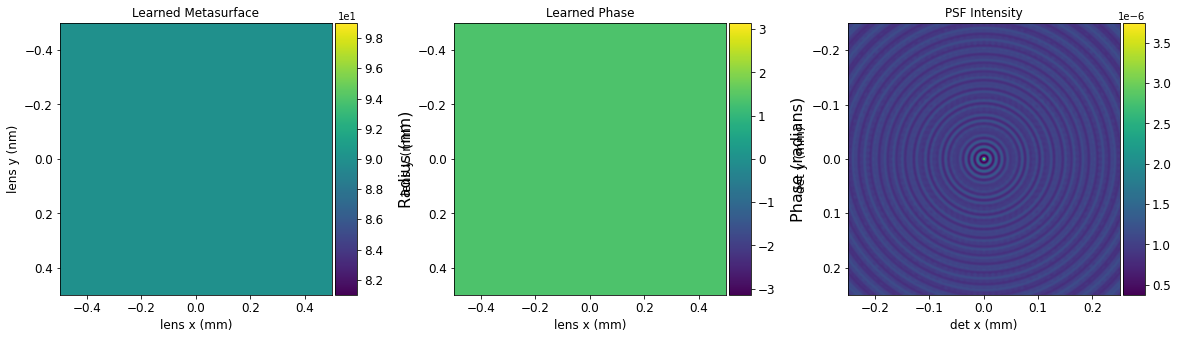

Training Log | (Step, time, loss):  0 0.6737072467803955 -3.7415245252083286e-06
Training Log | (Step, time, loss):  1 0.4678177833557129 -4.72309331567095e-06
Training Log | (Step, time, loss):  2 0.46738243103027344 -6.132055735431486e-06
Training Log | (Step, time, loss):  3 0.477036714553833 -8.579813298484425e-06
Training Log | (Step, time, loss):  4 0.4672873020172119 -1.2002126066751025e-05
Training Log | (Step, time, loss):  5 0.4690711498260498 -1.7069491803203958e-05
Training Log | (Step, time, loss):  6 0.46779513359069824 -2.4366239416728633e-05
Training Log | (Step, time, loss):  7 0.47063136100769043 -3.494186151731021e-05
Training Log | (Step, time, loss):  8 0.4675633907318115 -5.0577147740669966e-05
Training Log | (Step, time, loss):  9 0.47214531898498535 -7.345488599143035e-05
Log Training at step: 10


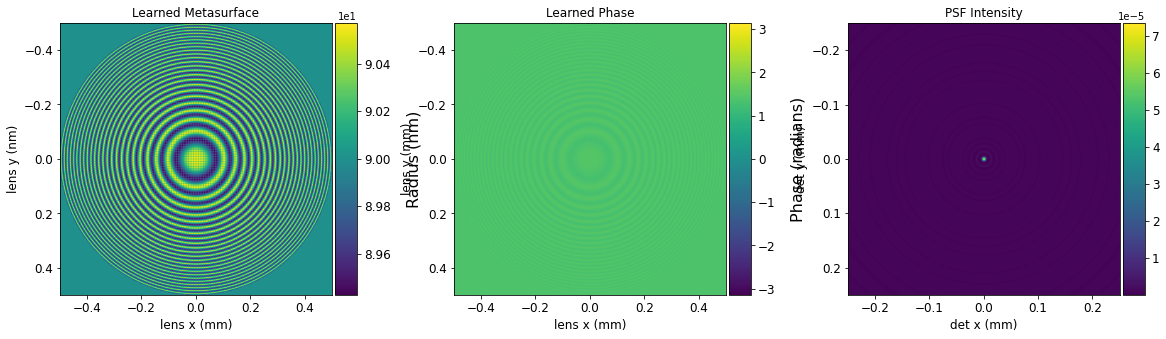

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:74: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")


Training Log | (Step, time, loss):  10 0.6059281826019287 -0.00010672882404701664
Training Log | (Step, time, loss):  11 0.4855306148529053 -0.00015509258968109067
Training Log | (Step, time, loss):  12 0.48866724967956543 -0.00022486757261000435
Training Log | (Step, time, loss):  13 0.4826817512512207 -0.00032141260382848383
Training Log | (Step, time, loss):  14 0.47032785415649414 -0.0004562772884862238
Training Log | (Step, time, loss):  15 0.4706747531890869 -0.0006416698598837306
Training Log | (Step, time, loss):  16 0.4709157943725586 -0.0008822627062238485
Training Log | (Step, time, loss):  17 0.46909308433532715 -0.0011776799677391573
Training Log | (Step, time, loss):  18 0.46735429763793945 -0.0015352945362742513
Training Log | (Step, time, loss):  19 0.46587610244750977 -0.0019675160906109223
Log Training at step: 20


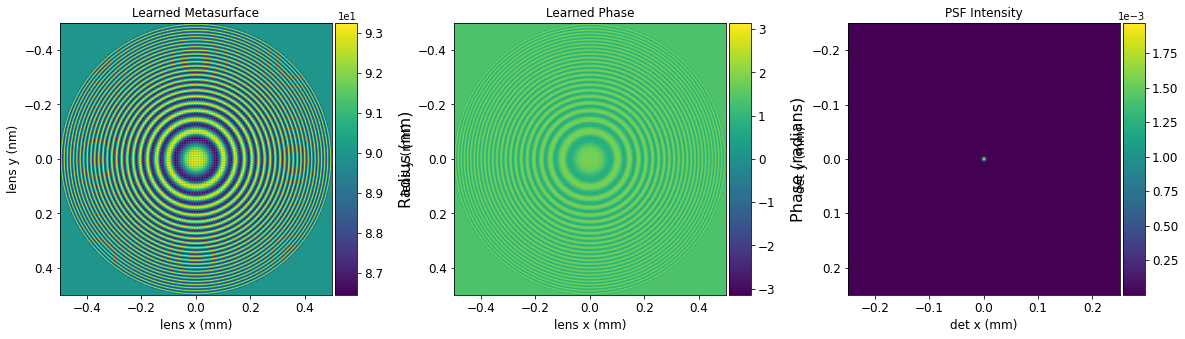

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:74: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")


Training Log | (Step, time, loss):  20 0.5833361148834229 -0.0024638368146684513
Training Log | (Step, time, loss):  21 0.47405576705932617 -0.0030332197161192826
Training Log | (Step, time, loss):  22 0.46787333488464355 -0.0036743541006598194
Training Log | (Step, time, loss):  23 0.46892833709716797 -0.004403730999482384
Training Log | (Step, time, loss):  24 0.46996593475341797 -0.005230664534542357
Training Log | (Step, time, loss):  25 0.4692416191101074 -0.006117714145592564
Training Log | (Step, time, loss):  26 0.4714844226837158 -0.007022304975781307
Training Log | (Step, time, loss):  27 0.47054147720336914 -0.008002296978609429
Training Log | (Step, time, loss):  28 0.4722328186035156 -0.008996344917280482
Training Log | (Step, time, loss):  29 0.47065258026123047 -0.009996773788913624
Log Training at step: 30


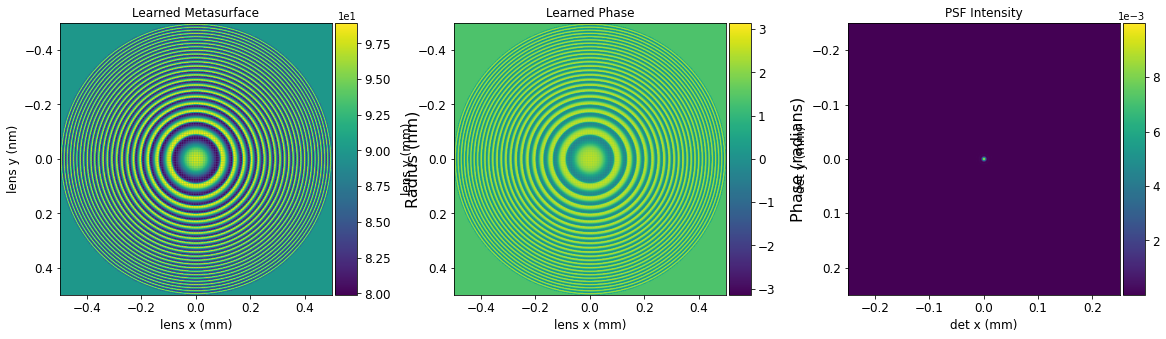

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:74: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")



 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:74: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")


In [ ]:
optimize_metalens_mlp(radial_symmetry=False, num_epochs=30, try_gpu=True)